# Groover Technical test

This notebook presents the results obtained in the context of the Groover data science internship test by Julien Guinot. Part 1 is a summarization of a research paper which can be found in pdf file in the directory in which this notebook was sent

## Part 2

In part 2, we are provided with 19 raw WAV files containing samples of music from the Groover library. All samples are 30s long, though not exactly of the same size. For image feature extraction such as spectrograms, we will have to apply padding to the images to attain fixed-length input . Our goal is to extract audio features to be later used for a given machine learning task.

That being said, we are looking to extract audio features which are crucial for classification tasks or recommendation tasks. many common audio features exist, including but not limited to:

- Mel frequency cepstral coefficients, a representation of the spectral envelope of an audio signal
- Tempo, which is crucial to genre classification
- Spectrogram
- Spectral Centroid
- Zero crossing rate
- Spectral bandwidth
- Total harmonic distortion
- etc.

We will be building a dataset comprised of audio features for both song level and beat level features. This means we will compute the features for each song (30s clip), attribute a tempo to the song and split the signal according to this evaluated tempo, and re-compute the features for each beat split from the original signal. This will provide a global feature value for each clip and also allow us to look into more detail, which will be useful for tasks such as chorus loudness analysis when compared to the verse.

All this can be achieved using the Librosa library, which is particularly adapted for audio signal feature extraction tasks.

## Part 3

For part 3, we are provided with a pre-constructed dataset of audio features for 1000 fixed length songs. the goal here is to build a genre classification model based on the provided features with respect to the single-label ground truth column  in the dataset, which will be explored later. To do this, we will:

- Have a preliminary section of exploratory data analysis on the features of the provided dataset # almost done
- Consider relevant features and/or feature engineering opportunities 
- Conduct pre-processing, including but not limited to : cleaning the data, scaling the data, augmenting the data # almost done
- Split the data into training, test, and validation data (consider K-fold validation for optimal model selection) # almost done
- establish relevant training metrics for multi-class classification problem) # almost done
- Establish a baseline using common out-of-the-box classification models (logistic regression, naive bayes, random forest, MLP...) # almost done
- Select a few models to fine-tune
- Conduct a grid search for optimal hyperparameters on the selected model
- Compare our final most relevant model's results with the others and perhaps with state of the art models





## Basic imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch
import keras
import sklearn
import librosa
from src.Audio_proc_utils import AudioFeatureExtractor
from src.Preproc_utils import train_test_val_split
from src.Training_utils import plot_learning_curve


sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

## Part 2

As previously stated, the goal of this section is to extract audio features from the 20 audio files provided as raw data. Many available audio features are available to be extracted and useful for audio tasks, but we focus on a few criteria:

- having a mix of high, mid and low level features. high-level features can be understood by humans: key, timbre, rythm. Mid-level features are agregated of low-level features than can be felt but not quantified by human ears (MFCC coefficients, dynamic range...). Low-level features mean nothing for humans but can be interpreted by a machine learning algorithm (RMS, Spectral Centroid...)

- Extracting a large amount of features to allow for down the road feature engineering and wealth of choice for any possible task

- Save on computation power : If a feature needs to be extracted by means of a costly ML algorithm, we choose to drop it.

This being said, we choose to focus on the following features:

#### High-level 

- Tempo
- Duration
- Key

#### Mid-level

- MFCC coefficients mean and std
- Dynamic range
- transient strength
- Band energy ratio
- Amplitude envelope mean
- harmonic to percussive ratio

####

- RMS mean and standard deviation
- Spectral centroid, contrast, rolloff, bandwidth mean and standard deviation
- harmonic and percussive elements RMS mean
- Zero crossing rate 
- Chroma STFT and CENS mean and standard deviation
- Spectrogram, Mel-Spectrogram, Chromagram

*The code containing all of the processing steps can be found at the following github repo in src/Audio_proc_utils.py*

https://github.com/Pliploop/Groover_Tech_Test

In [2]:

extractor = AudioFeatureExtractor()
generate = False
if generate:
    dataset_extracted = extractor.build_30s_dataset()

In [3]:
try:
    display(dataset_extracted.head())
except:
    pass

In [4]:
# sns.kdeplot(dataset_extracted.HPR)

#### To-do

- Save the spectrograms and other 2-D arrays to corresponding folders
- Split file according to tempo
- Conduct same analysis on split segments
- Possible high-level additions:
    - Key detection
    - Transient strength (onset strength)
    - amplitude envelope
    - Band energy ratio

## Part 3

In [5]:
dataset = pd.read_csv('data/part3_GrooverChallengeDataset.csv')

In [6]:
dataset.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [7]:
dataset.columns

Index(['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
       'label'

In [8]:
dataset.label.unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

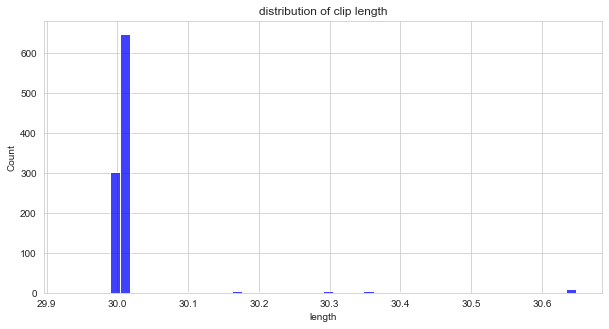

In [9]:
fig,ax = plt.subplots(figsize=(10,5))
sns.histplot(dataset.length/22050,bins=50,color='b')
plt.title('distribution of clip length')
display()

In [10]:
dataset[dataset.isnull()].count().sum()

0

In [11]:
dataset.groupby('label').count().length

label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: length, dtype: int64

<AxesSubplot:xlabel='label', ylabel='tempo'>

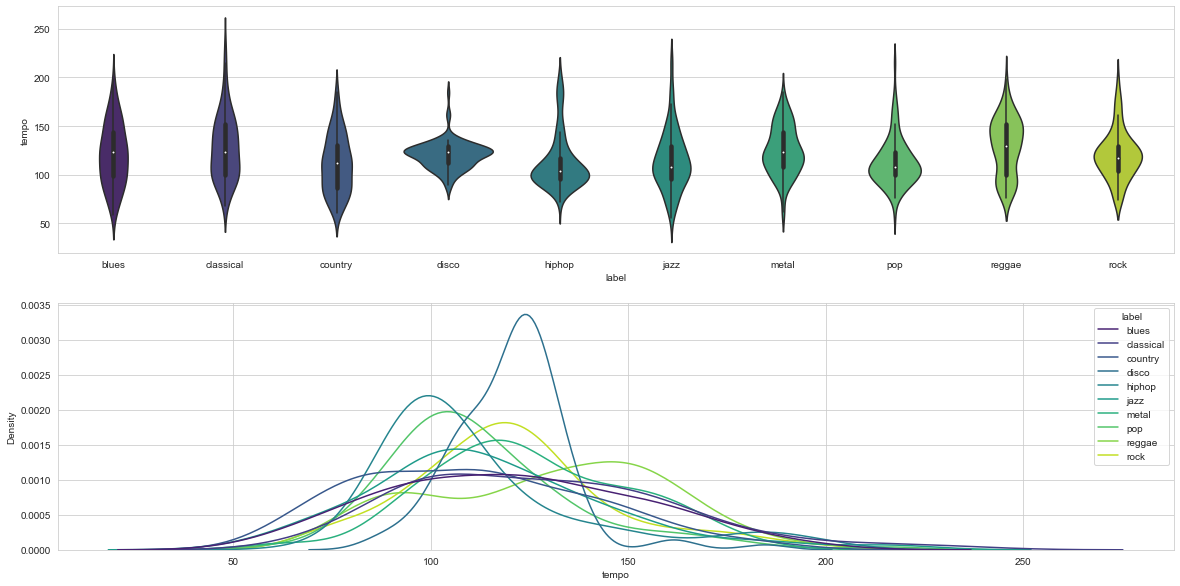

In [12]:
fig,ax=plt.subplots(2,1,figsize=(20,10))
sns.kdeplot(data=dataset,x='tempo',hue='label',palette='viridis',ax=ax[1])
sns.violinplot(data=dataset,y='tempo',x='label',palette='viridis',ax=ax[0])

### Data pre-processing

#### Min-max scaling, one-hot encoding and label encoding

We use min-max scaling to constrain all the features to the same range of (0-1). this allows us to negate the problems linked with high feature values leading to exploding weights. Furthermore, we use label encoding for single-output models ground truth (SVM, K-means), and one-hot encoding for multi-output models (SVM, MLP)

In [13]:
features = dataset.drop(columns=['label'])
gt  = dataset.label

In [14]:
le = sklearn.preprocessing.LabelEncoder()
ohe = sklearn.preprocessing.LabelBinarizer()
y_labels = le.fit_transform(gt)
y_ohe = ohe.fit_transform(y_labels)

In [15]:
mms = sklearn.preprocessing.MinMaxScaler()
X = mms.fit_transform(features)

#### Train-test-validation split

We use a 60-20-20 train-test-validation due to the low amount of data we have (1000 samples). We will also be validating our optimal model through K-fold cross validation later on.

In [16]:
X_train,X_test,y_train,y_test = train_test_val_split(X,y_labels,train_size=.9)

### metrics

#### Multiclass classification metrics

The usual multiclass classification metrics are the following

- global accuracy
- macro-averaged precision, recall, f1 score
- confusion matrix

In our case, recall is the sub-metric which interests us the most, as it represents the percentage of the time the model is able to predict each class wheren presented with a positive sample for the class. Essentially, our use case makes us consider the optimal model to be one that does not overshoot but retrieves the correct genre often when presented with each genre, with oppiosition to precision, which minimises false predictions.

We use macro-averaged metrics as there is no class imbalance and thus the arithmetic mean of each metric does not need to take into account class imbalance, which micro-averaging is for. 

#### Single-class one vs all metrics

Once our optimal model is established, it is interesting to consider its performance on all of the classes individually by considering a binary classification problem. This is useful to identify classes where classification does not function optimally to devise preprocessing strategies for better results. 



### Testing some out-of-the-box models

In this section, we implement some basic classification algorithms from sklearn, out of the box. We use provided default values or values obtained by quick trial-and-error to establish a baseline for all models, and use k-fold validation to compute average accuracy, maximum accuracy, and minimum accuracy for each model.

This will allow us to isolate our top 3 models which we will then fine-tune to reach best accuracy values.

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "poly SVM",
    "Decision Tree",
    "Random Forest",
    "Naive Bayes",'logreg','MLP','XGBoost'
]

KNN = KNeighborsClassifier(20)
LinSVM = SVC(kernel="linear", C=0.025)
rbfSVM = SVC(gamma=0.1, C=1)
polySVM = SVC(kernel="poly", C=0.005, degree = 5)
DT = DecisionTreeClassifier(max_depth=5,max_features='auto')
# RF = RandomForestClassifier(max_depth=10, n_estimators=400,max_features='auto')
RF = RandomForestClassifier(max_depth=5, n_estimators=500,max_features=4,min_samples_leaf=10)
NB = GaussianNB()
Logreg = LogisticRegression(C=0.1)
NN = MLPClassifier((80,40),batch_size=100,alpha=0.04,max_iter=2000)
XGB = GradientBoostingClassifier(n_estimators=400,max_features='auto',learning_rate=0.1,subsample=0.5)

out_of_the_box = [KNN, LinSVM, rbfSVM, polySVM, DT, RF, NB,Logreg, NN, XGB]

In [36]:
from src.Evaluation_utils import score_classifier

In [37]:
out_of_the_box_results = []

for classifier in out_of_the_box:
    classifier.fit(X_train,y_train)
    out_of_the_box_results.append(list(score_classifier(classifier,X_test,y_test)))

out_of_the_box_results = pd.DataFrame(out_of_the_box_results,columns = ['accuracy','precision','recall','f1'],index=names)

In [38]:
out_of_the_box_results.T

,Nearest Neighbors,Linear SVM,RBF SVM,poly SVM,Decision Tree,Random Forest,Naive Bayes,logreg,MLP,XGBoost
accuracy,0.66000,0.380000,0.620000,0.630000,0.350000,0.700000,0.500000,0.490000,0.720000,0.770000
precision,0.66000,0.380000,0.620000,0.630000,0.350000,0.700000,0.500000,0.490000,0.720000,0.770000
recall,0.71576,0.309721,0.641832,0.666342,0.382197,0.704123,0.476349,0.592914,0.741991,0.784936
f1,0.65711,0.288621,0.616260,0.623927,0.333865,0.694492,0.461306,0.459727,0.722421,0.768084


<AxesSubplot:xlabel='value', ylabel='index'>

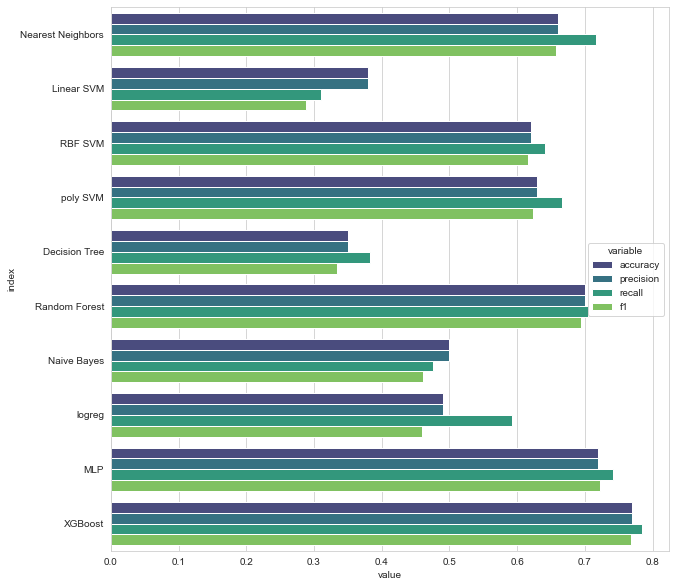

In [39]:
plotting_data = pd.melt(out_of_the_box_results.reset_index(),id_vars='index',value_vars=['accuracy','precision','recall','f1'])

fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(data=plotting_data,y='index',hue='variable',x='value',palette='viridis')

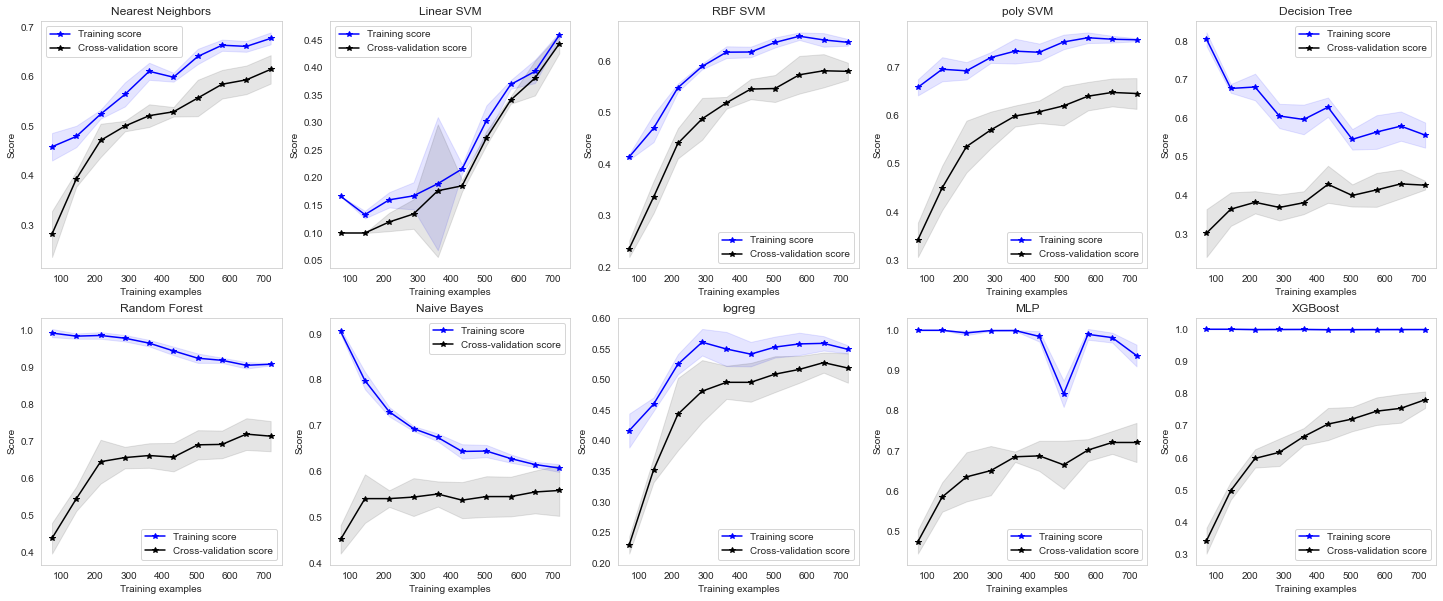

In [40]:

fig,axes = plt.subplots(2,5,figsize=(25,10))

classifier=0
for ax in axes:
    for subax in ax:
        plot_learning_curve(out_of_the_box[classifier],names[classifier],X_train,y_train,axes=subax,cv=5,n_jobs=10)
        classifier+=1
    

# plot_learning_curve(rbfSVM,'MLP classifier',X_train,y_train)

10-Fold cross validation reveals our top 3 optimal models. We rely not only on pure accuracy, but also recall, shown previously to be our metric of preference for this use case, explainability and customization capabilities. Our attention lands on these three models, which will now be submitted to a hyperparameter grid search to determine optimal hyperparameter values on the test set:

- XGBoost, for its high customization cpaabilities and features importance analysis possibilities
- MLP, for its high customization
- Random forest, for its explainability

and all of these models because they scored top 3 in terms of best accuracy with our test data validation

### To-do

- Finish EDA
- Isolate our three top models
- Conduct Grid search of hyperparameters
- Build confusion matrices
- Explainability graph for XGBoost/rforest
- Select optimal model
- Perform K-fold validation
- Build custom MLP with keras/torch
- Training curves for MLP
- compare
- compare with SOTA